<h2> NewYork City Taxi Fare Prediction </h2>

<b>Problem Description</b>: In this problem we are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

<b>Problem link</b> : <href>https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/ </href>

<b>Evaluation Metric</b> : The evaluation metric for this competition is the root mean-squared error or RMSE. RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better. One nice property of RMSE is that the error is given in the units being measured, so you can tell very directly how incorrect the model might be on unseen data.

RMSE is given as below:


$RMSE = \sqrt{\frac{1}{n} \sum^{n}_{i=1} (\hat{y}_i - y_i)^2}$

where $y_i$ is the ith observation and $\hat{y}_i$ is the prediction  for that observation

<h3> 1. First we Import the necessary modules:

In [46]:
import numpy as np
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot
import itertools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

import dask.dataframe as dsk
import folium

from sklearn.metrics import mean_squared_error as mse
from IPython.display import Math

<h3>1. Importing data and quick Data Exploration:

In [2]:
data_5m = pd.read_csv("Data/train.csv",nrows = 5000000)
data_5m.shape

(5000000, 8)

In [3]:
data_5m.shape[0]

5000000

In [4]:
data_5m.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
#Checking datatypes
data_5m.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
data_5m.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


From the above description , we see:<br>
1. There are negative fare amount in the data sample.I am removing those datapoints from the data sample in the removing outlier section.<br>
2. Average fare amount is around 11.3 dollars and has a std of 9.7 dollars.

3. Maximum  fare amount is around 1273 dollars which is very high.Need to check for outliers in fare amount values.

4. maximum passenger count is 208 which seems impossible.

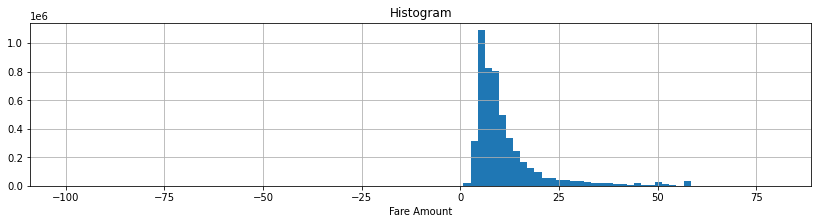

In [7]:
# plotting histogram of fare
data_5m[data_5m.fare_amount<80].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('Fare Amount')
plt.title('Histogram');

--> Maximum trips have fare amount lower than 20 dollars

<h3> 2. Data Cleaning and Feature Extraction </h3>

<b>2.1 Checking columns with null values:

In [8]:
print(data_5m.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64


--> There are missing values in dropoff latitudde and longitude.

<b>2.2 Removing the rows with null values

In [9]:
data_5m = data_5m[data_5m['dropoff_longitude'].notnull()]
data_5m = data_5m[data_5m['dropoff_latitude'].notnull()]

<b>2.3 Date Time Handling:

In [10]:
data_5m['pickup_datetime'] = data_5m['pickup_datetime'].str.replace(" UTC","")
data_5m['pickup_datetime'] = pd.to_datetime(data_5m['pickup_datetime'])

<b>2.4 Creating separate features for Year, Month , Day and some other special features

In [11]:
mapping = {1:"01-JAN",2:"02-FEB",3:"03-MAR",4:"04-APR",5:"05-MAY",6:"06-JUN",7:"07-JUL",
           8:"08-AUG",9:"09-SEP",10:"10-OCT",11:"11-NOV",12:"12-DEC"}

data_5m["year"]  = data_5m["pickup_datetime"].dt.year
data_5m["month"] = data_5m["pickup_datetime"].dt.month
data_5m["day"] = data_5m["pickup_datetime"].dt.day
data_5m["month_name"] = data_5m["month"].map(mapping)

#merge year month
data_5m["month_year"] = data_5m["year"].astype(str) + " - " + data_5m["month_name"]
#extract week day 
data_5m["week_day"] = data_5m["pickup_datetime"].dt.strftime("%A")
#extract hour
data_5m["hour"] = data_5m["pickup_datetime"].dt.hour 
#Sorting the data according to date time
data_5m = data_5m.sort_values(by = "pickup_datetime",ascending = False)

<b>2.5 Creating new feature: </b> Log of fare amount. This feature will convert the extremely small positive valued fare amount(> 0 and <1) to negative infinity which can be removed. 

In [12]:
#Log of fare amount
data_5m['fare_log'] = np.log(data_5m['fare_amount'])
data_5m.fare_log.describe()

count    4.999753e+06
mean             -inf
std               NaN
min              -inf
25%      1.791759e+00
50%      2.140066e+00
75%      2.525729e+00
max      7.149375e+00
Name: fare_log, dtype: float64

In [27]:
data_5m = data_5m[data_5m.fare_log > 0]

<b>2.6 Creating new feature : Distance of trips</b>:<br>

<b> Haversine Distance</b> : The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes(<href>https://en.wikipedia.org/wiki/Haversine_formula</href>) <br>

It can be calculated using the below formula: <br>
* lon_dist = lon2 - lon1 
* lat_dist  = lat2 - lat1 
* a = (sin(lat_dist/2))^2 + cos(lat1) * cos(lat2) * (sin(lon_dist/2))^2 
* c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
* d = R * c (where R is the radius of the Earth)<br>


In [13]:
def haversine_vectorize(lat_1, lon_1, lat_2, lon_2):
    lat_1, lon_1, lat_2, lon_2 = map(np.radians, [lat_1, lon_1, lat_2, lon_2])
    lon = lon_2 - lon_1
    lat = lat_2 - lat_1
    haver_formula = np.sin(lat/2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(lon/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

data_5m['trip_distance'] = haversine_vectorize(data_5m["pickup_latitude"], data_5m["pickup_longitude"], 
                                              data_5m["dropoff_latitude"],data_5m["dropoff_longitude"])

#create new variable log of distance
data_5m["log_trip_distance"] = np.log(data_5m["trip_distance"])

<h3>2.7 Analysing outliers:</h3>

<b> 2.7.1 Fare Amount analysis</b>

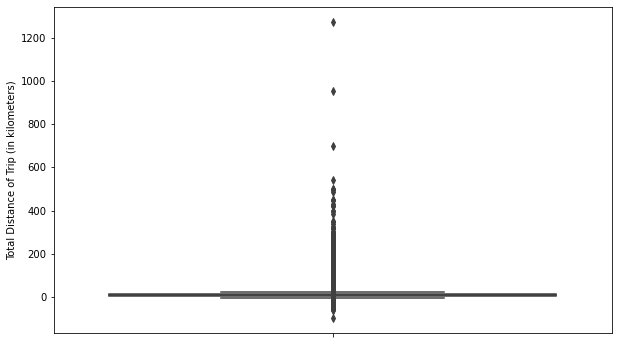

In [14]:
plt.figure(figsize = (10,6))
sns.boxplot("fare_amount", data = data_5m, orient = "v")
plt.ylabel("Total Distance of Trip (in kilometers)")
plt.show()

In [15]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(0,1,11):
    print("{} percentile value is {} dollars".format(np.round(i,2),np.round(data_5m['fare_amount'].quantile(i),2)))

0.0 percentile value is -100.0 dollars
0.1 percentile value is 4.5 dollars
0.2 percentile value is 5.5 dollars
0.3 percentile value is 6.5 dollars
0.4 percentile value is 7.3 dollars
0.5 percentile value is 8.5 dollars
0.6 percentile value is 9.7 dollars
0.7 percentile value is 11.5 dollars
0.8 percentile value is 14.1 dollars
0.9 percentile value is 20.5 dollars
1.0 percentile value is 1273.31 dollars


In [16]:
for i in np.linspace(0.9,1,11):
    print("{} percentile value is {} dollars".format(np.round(i,2),np.round(data_5m['fare_amount'].quantile(i),2)))

0.9 percentile value is 20.5 dollars
0.91 percentile value is 21.7 dollars
0.92 percentile value is 23.3 dollars
0.93 percentile value is 25.3 dollars
0.94 percentile value is 27.7 dollars
0.95 percentile value is 30.33 dollars
0.96 percentile value is 33.5 dollars
0.97 percentile value is 38.5 dollars
0.98 percentile value is 46.83 dollars
0.99 percentile value is 53.0 dollars
1.0 percentile value is 1273.31 dollars


In [17]:
#Removing the outliers
data_5m = data_5m[data_5m['fare_amount'] < data_5m['fare_amount'].quantile(0.9999)]

#dropping rows with fareamount  less than 0
data_5m = data_5m[ (data_5m["fare_amount"] >= 0 ) ]

<b>2.7.2 Analysing Passenger counts and map coordinates that occur very rare:

In [44]:
#dropping rows with passengers greater than 7 and equals 0
data_5m = data_5m[(data_5m["passenger_count"] > 0 ) & (data_5m["passenger_count"] < 8) ]

#Dropping rarely occuring values of pickup and dropoff coordinates
coordinates = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for c in coordinates:
    data_5m = data_5m[(data_5m[c] > data_5m[c].quantile(0.001)) & (data_5m[c] < data_5m[c].quantile(0.999))]

<b>2.7.3 Analysis of trip distance for outliers:

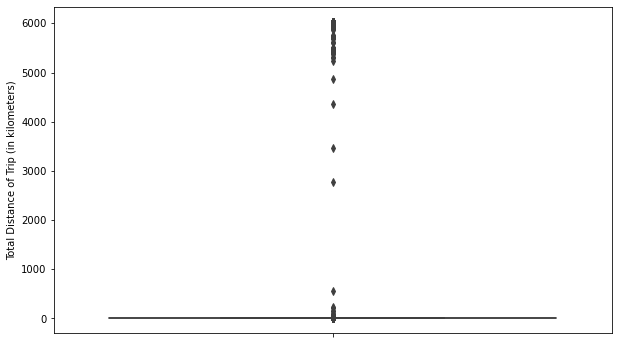

In [19]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_distance", data = data_5m, orient = "v")
plt.ylabel("Total Distance of Trip (in kilometers)")
plt.show()

In [20]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(0,1,11):
    print("{} percentile value is {} min".format(np.round(i,2),data_5m['trip_distance'].quantile(i)))

0.0 percentile value is 0.0 min
0.1 percentile value is 0.7865012195217517 min
0.2 percentile value is 1.1043720411338434 min
0.3 percentile value is 1.4081443117027712 min
0.4 percentile value is 1.7476644749472365 min
0.5 percentile value is 2.146311213540471 min
0.6 percentile value is 2.6560598000020486 min
0.7 percentile value is 3.3767826438183866 min
0.8 percentile value is 4.538023808141443 min
0.9 percentile value is 6.902541688872532 min
1.0 percentile value is 6029.785795945615 min


In [21]:
for i in np.linspace(0.9,1,11):
    print("{} percentile value is {} min".format(np.round(i,2),data_5m['trip_distance'].quantile(i)))

0.9 percentile value is 6.902541688872532 min
0.91 percentile value is 7.347316877785442 min
0.92 percentile value is 7.888794262117825 min
0.93 percentile value is 8.536642289141286 min
0.94 percentile value is 9.172566990668011 min
0.95 percentile value is 9.803206326802693 min
0.96 percentile value is 10.65499781800833 min
0.97 percentile value is 12.373666516777105 min
0.98 percentile value is 15.612254417178402 min
0.99 percentile value is 20.218506633075457 min
1.0 percentile value is 6029.785795945615 min


In [22]:
data_5m = data_5m[data_5m['trip_distance'] < data_5m['trip_distance'].quantile(0.9999)]

<b>2.7.4 Analysing Pickup and Dropoff Location Data </b><br>

Source: (https://www.flickr.com/places/info/2459115):
New York is bounded by the location coordinates(latitude, longitude) - (40.5774, -74.15) & (40.9176,-73.7004).Hence any datapoints with coordinates(including both pickups and drop-offs) that are outside the bounding coordinates of newyork city are needed to be dropped as we are only concerned with trips which happened within New York.


<b>Outliers : Visualizing Pickups outside Newyork

In [36]:
# outside_NYC = data_5m[((data_5m.pickup_latitude <= 40.5774) | (data_5m.pickup_longitude <= -74.15) |
#                        (data_5m.pickup_latitude >= 40.9176) | (data_5m.pickup_longitude >= -73.7004))]

# map_boundary = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")
# pickups_outside = outside_NYC.head(20000)

# for i,row in pickups_outside.iterrows():
#     if row["pickup_latitude"] != 0:
#         folium.Marker([row["pickup_latitude"], row["pickup_longitude"]]).add_to(map_boundary)
# map_boundary

<b>Outliers : Visualizing dropoffs outside neywork

In [ ]:
outside_NYC = data_5m[((data_5m.dropoff_latitude <= 40.5774) | (data_5m.dropoff_longitude <= -74.15) \
                          | (data_5m.dropoff_latitude >= 40.9176) | (data_5m.dropoff_longitude >= -73.7004))]

map_boundary = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")
dropoff_outside = outside_NYC.head(20000)

for i,row in dropoff_outside.iterrows():
    if row["dropoff_latitude"] != 0:
        folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]]).add_to(map_boundary)
map_boundary

<b> 2.7.5 Removing all pickup and dropoffs that were outside Newyork city:

In [23]:
data_5m = data_5m[(((data_5m.pickup_latitude >= 40.5774) & (data_5m.pickup_latitude <= 40.9176)) & \
                   ((data_5m.pickup_longitude >= -74.15) & (data_5m.pickup_longitude <= -73.7004)))]

data_5m = data_5m[(((data_5m.dropoff_latitude >= 40.5774) & (data_5m.dropoff_latitude <= 40.9176)) & 
                   ((data_5m.dropoff_longitude >= -74.15) &(data_5m.dropoff_longitude <= -73.7004)))]

<h3> 2.8 Creating new feature : Fare per kilometers </h3>

count    4.863231e+06
mean              inf
std               NaN
min      0.000000e+00
25%      2.981270e+00
50%      3.845219e+00
75%      5.112121e+00
max               inf
Name: fare_per_km, dtype: float64

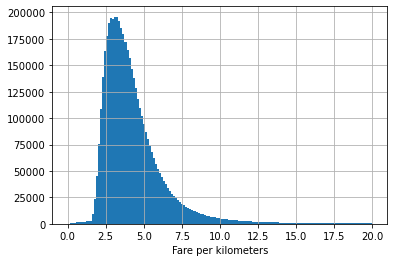

In [24]:
data_5m['fare_per_km'] = data_5m.fare_amount/data_5m.trip_distance
data_5m[data_5m.fare_per_km <20].fare_per_km.hist(bins = 150)
plt.xlabel("Fare per kilometers")

data_5m.fare_per_km.describe()

<h3>3. How much Data was lost by removal of outliers and missing values? </h3><br>

We show it with the help of a pie diagram.


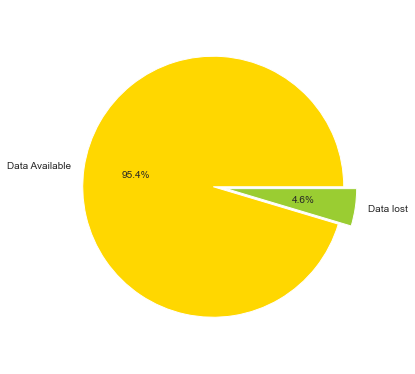

In [45]:
sizes = [data_5m.shape[0],5000000 - data_5m.shape[0]]
explode = (0.1, 0)
labels = 'Data Available', 'Data lost'
colors = ['gold', 'yellowgreen']
fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%')
plt.axis('equal')
plt.show()

About 4.6%(230000) datapoints from a data sample of 5000000 instances are lost which is quite reasonable

<h3>4. Cleaned Data visualisation </h3>

<b> 4.1 General Statistical summary of Features:

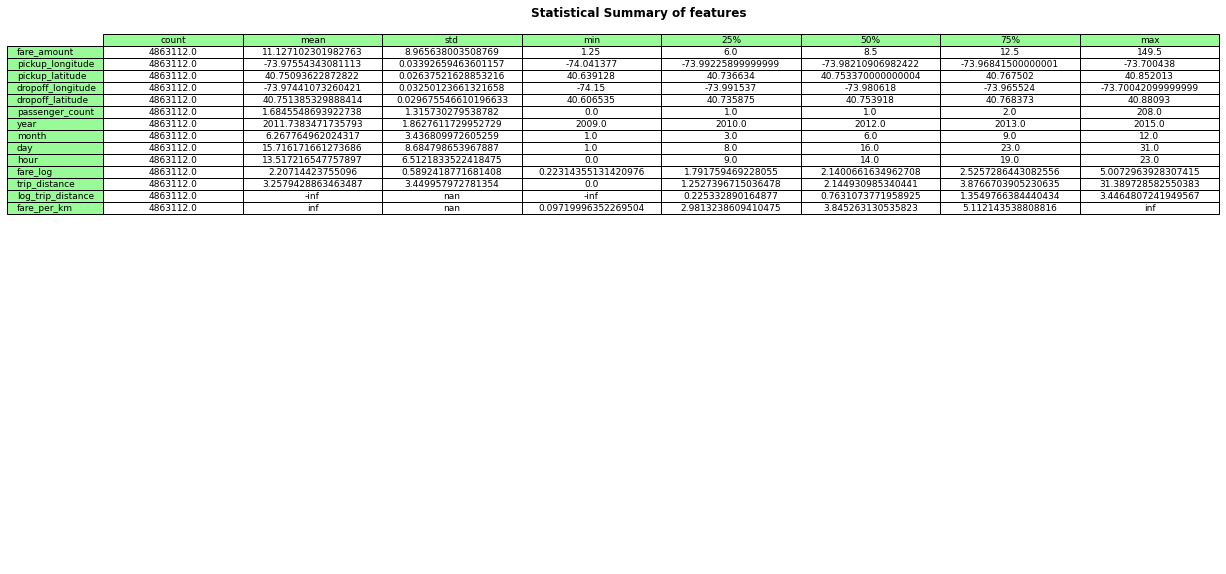

In [40]:
stats1 = data_5m.describe().reset_index()

list_data = []
for i in stats1.columns:
    if(i != 'index'):
         list_data.append(list(stats1[i]))
# print(list_data)
# list_data = [list_data[i].apply({lambda x: np.round(x,2)}) for i in range(8)]

fig, ax = plt.subplots(figsize=(20,10))
fig1.subplots_adjust(8,5,10,10)
ax.set_axis_off() 
table = ax.table( cellText = list_data,  rowLabels = stats1.columns.tolist()[1:],  colLabels = stats1['index'].values, 
    rowColours =["palegreen"] * 15,  colColours =["palegreen"] * 8, cellLoc ='center',  loc ='upper left')         
  
ax.set_title('Statistical Summary of features', fontweight ="bold")   
plt.show() 

<b> 4.2 Distribution of various numerical features in Data

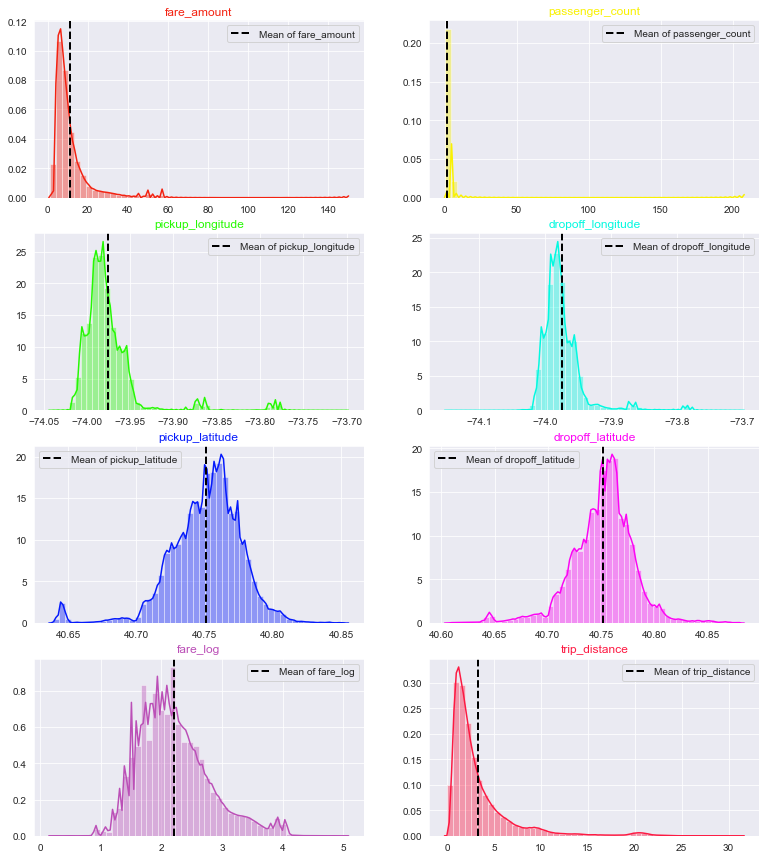

In [41]:
columns = ['fare_amount','passenger_count', 'pickup_longitude', 'dropoff_longitude','pickup_latitude', 'dropoff_latitude','fare_log','trip_distance']

length = len(columns)
color_codes = ["#F32211" ,"#F9F103","#26F903","#03F9E0","#051AFC","#FC05F4","#BB4FB7" , "#FD1942" ]

sns.set_style("darkgrid")
plt.figure(figsize = (13,15))
for i,j,k in itertools.zip_longest(columns,range(length),color_codes) :
    plt.subplot(length/2,length/4,j+1)
    sns.distplot(data_5m[i],color = k)
    plt.axvline(data_5m[i].mean(),linewidth  = 2 ,linestyle = "dashed",color = "k" ,label = "Mean of "+i)
    plt.legend(loc = "best")
    plt.title(i,color = k)
    plt.xlabel("")

<b> 4.3 Yearly count of total trips, total fare amount, total trip distance and total no of passengers 

<function matplotlib.pyplot.show(*args, **kw)>

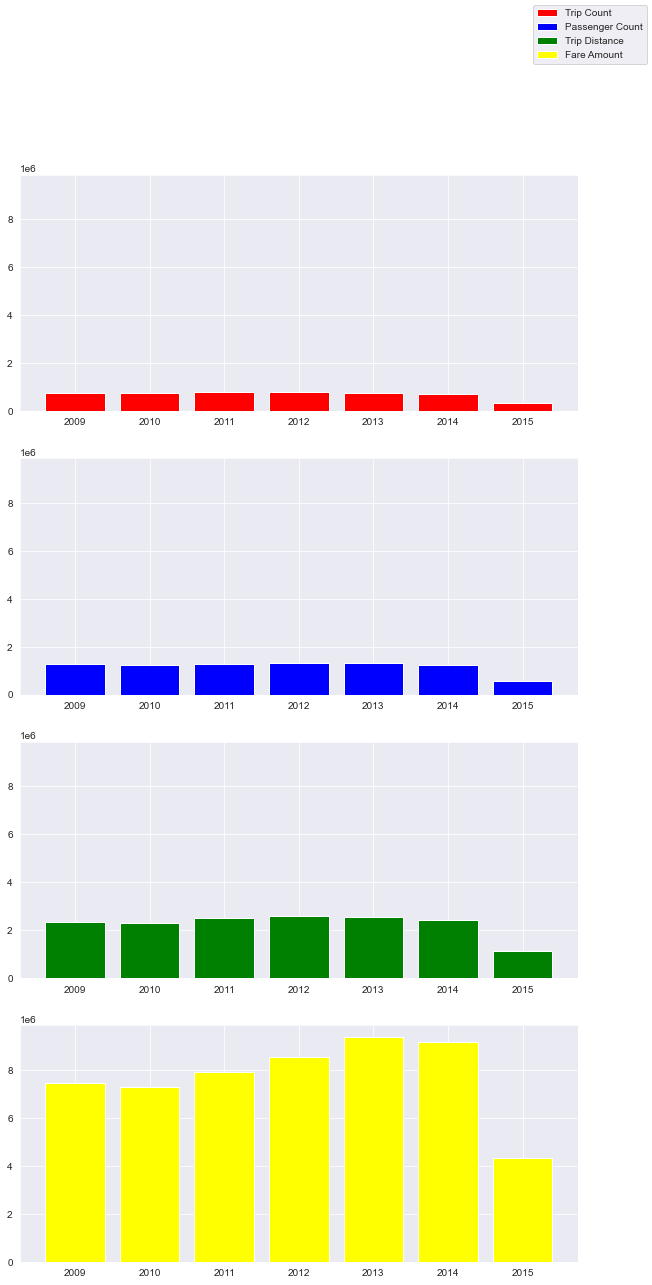

In [42]:
yearwise_stats  = data_5m.groupby("year").agg({"key":"count","fare_amount":"sum","passenger_count":"sum",
                                               "trip_distance" : "sum"}).reset_index()\
                                               .rename(columns = {"key" : "trip_count"})

f, ax = plt.subplots(4,1, sharey='col',figsize=(10,20))
#plotting trips ,passengers and fare amount by year

ax[0].bar(yearwise_stats["year"],yearwise_stats["trip_count"],color = 'red',label = 'Trip Count')

ax[1].bar(yearwise_stats["year"],yearwise_stats["passenger_count"],color = 'blue',label='Passenger Count')

ax[2].bar(yearwise_stats["year"],yearwise_stats["trip_distance"],color = 'green',label = 'Trip Distance')

ax[3].bar(yearwise_stats["year"],yearwise_stats["fare_amount"],color = 'yellow',label = 'Fare Amount')
f.legend(loc="upper right")
plt.show

<b>4.4 Trend in Trips:</b>
    
Monthly:

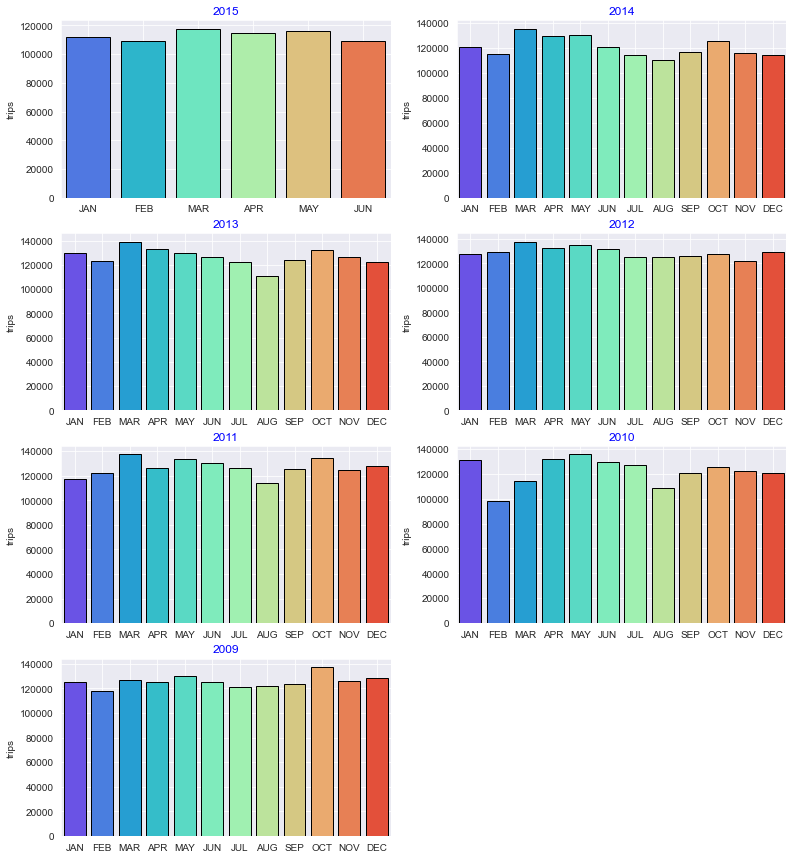

In [34]:
years = [i for i in data_5m["year"].unique().tolist()]
data = data_5m[data_5m["year"].isin(years)]

plt.figure(figsize = (13,15))
for i,j in itertools.zip_longest(years,range(len(years))) :
    plt.subplot(4,2,j+1)
    trip_counts_mn = data[data["year"] == i]["month_name"].value_counts()
    trip_counts_mn.sort_index(inplace = True)
    trip_counts_mn = trip_counts_mn.reset_index()
    trip_counts_mn['index'] = trip_counts_mn['index'].apply(lambda x: str(x).split('-')[1])
    sns.barplot(trip_counts_mn['index'],trip_counts_mn['month_name'],palette = "rainbow",linewidth = 1,edgecolor = "k"*data["month_name"].nunique() )
    plt.title(i,color = "b",fontsize = 12)
    plt.grid(True)
    plt.xlabel("")
    plt.ylabel("trips")

WeekDays:

In [61]:
def plot_day_trend(year) :
    day_count = data[data["year"] == year]["week_day"].value_counts().reset_index()
    day_count.columns = ["day","count"]
    day_count["order"]  = day_count["day"].replace({"Sunday" :1,'Monday' : 2, 'Tuesday': 3,'Wednesday':4,'Thursday' :5, 'Friday':6,
                                                    'Saturday':7})
    day_count = day_count.sort_values(by = "order",ascending  = True)
    tracer = go.Bar(x = day_count["day"],y = day_count["count"],name = year,marker = dict(line = dict(width =1)))
    return tracer

#layout
layout = go.Layout(dict(title = "Trend in trips  by weekdays",xaxis = dict(title = "weekday"),yaxis = dict(title = "count"),))

t  = plot_day_trend(2009)
t1 = plot_day_trend(2010)
t2 = plot_day_trend(2011)
t3 = plot_day_trend(2012)
t4 = plot_day_trend(2013)
t5 = plot_day_trend(2014)

data = [t,t1,t2,t3,t4,t5]
py.iplot(go.Figure(data = data,layout=layout))

<img src='newplot.png'>

Hour of the day:

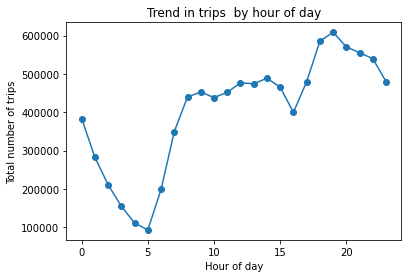

In [63]:
trips_hour = data_5m["hour"].value_counts().reset_index()
trips_hour.columns = ["hour","count"]
trips_hour = trips_hour.sort_values(by = "hour",ascending = True)

plt.scatter(x = trips_hour["hour"],y = trips_hour["count"])
plt.plot(trips_hour["hour"],trips_hour["count"])
plt.xlabel("Hour of day")
plt.ylabel("Total number of trips")
plt.title("Trend in trips  by hour of day")
plt.show()

<b> 4.5 Correlation Matrix

In [52]:
total_fare = (data_5m.groupby(["year","month","month_name","month_year"]).agg({'fare_amount':'sum'}).reset_index())
count_trip  = data_5m.groupby(["year","month","month_name"])["month_year"].value_counts().to_frame()
count_trip = count_trip.rename(columns = {"month_year" : "count"})
count_trip = count_trip.reset_index()
count_passenger = data_5m.groupby(["year","month","month_name","month_year"]).agg({'passenger_count':'count'}).reset_index()
trip_dist_sum = data_5m.groupby(["year","month","month_name","month_year"]).agg({'trip_distance':'sum'}).reset_index()


#Merge passenger_count,trip_count and fare_amount data 
count_trip_passenger  = count_trip.merge(count_passenger,left_on = "month_year",right_on = "month_year",how= "left")
sum_fare_trip_distance  = total_fare.merge(trip_dist_sum,left_on = "month_year",right_on = "month_year",how= "left")

data_final = count_trip_passenger.merge(sum_fare_trip_distance,left_on = "month_year",right_on = "month_year",how= "left")
data_final = data_final[["month_year","count","passenger_count","fare_amount","trip_distance","month_x_x","year_x_x","month_name_x_x"]]


data_final = data_final.rename(columns = {"month_x_x":"month","year_x_x":"year","count" : "trips_count",
                                          "month_name_x_x":"month_name"})
#correlation
correlation  =  np.array(data_final[['trips_count', 'passenger_count','fare_amount', "trip_distance"]].corr())
correlation  =  np.around(correlation,4)


#x & y ticks
ticks =  ['trips_count', 'passenger_count', 'fare_amount', "trip_distance"]
#plot heatmap
fig = ff.create_annotated_heatmap(z = correlation,x = ticks,y = ticks,showscale=True,colorbar = dict(title = "correlation coefficient",titleside = "right"))
fig.layout.title  = "Correlation Matrix"
fig.layout.margin = dict(l = 200,r = 200)
py.iplot(fig)

<img src='correlation_matrix.png'>

<b> 4.5 Fare amount vs trip distance </b>

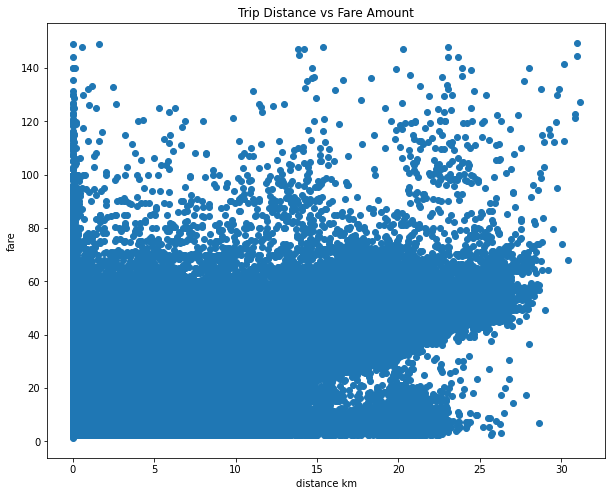

In [30]:

plt.figure(figsize = (10,8))
plt.scatter(data_5m.trip_distance,data_5m.fare_amount)
plt.xlabel('distance km')
plt.ylabel('fare')
plt.title('Trip Distance vs Fare Amount')
plt.show()

Observing the above plot, we see that:<br>
1. There are some trips with very less distance but hight price.These could just be errors.Also the distance is from pickup to dropoff location and not total distance by road.So these trips might be pickup from  and dropoff to the same location. So removing data points with very small distance(less than half kilometers range)

2. There  are trips with large distances but low fare.Perhaps these might be discounted fares.Some of thesee trips might be fixed fared trips from and to the airport.

3. On the average , the fare and distance has a rate of 3.23 USD per kilometer.


In [31]:
idx = (data_5m.trip_distance >= 1)
data_5m = data_5m[idx]

In [32]:
data_5m.trip_distance.describe()

count    4.057835e+06
mean     3.776125e+00
std      3.553292e+00
min      1.000002e+00
25%      1.656396e+00
50%      2.554611e+00
75%      4.403732e+00
max      3.115368e+01
Name: trip_distance, dtype: float64

In [33]:
data_5m.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()

,trip_distance,fare_amount
passenger_count,,
0,3.254640,9.731126
1,3.727392,12.042149
2,3.947541,12.650706
3,3.820805,12.397874
4,3.856789,12.557136
5,3.828413,12.150204
6,3.891790,13.248149
7,1.622121,8.500000
9,9.445815,37.040000


In [34]:
print("Average fare per mile = ",data_5m.fare_amount.sum()/data_5m.trip_distance.sum(), " $USD/km")

Average fare per mile =  3.226843273061009  $USD/km


<b>4.6 Fare per kilometer vs trip distance

Text(0, 0.5, 'fare per distance kilometers')

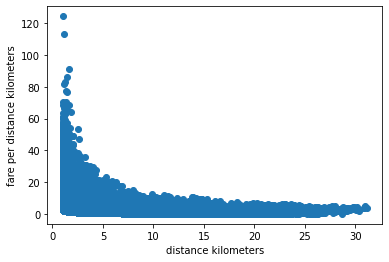

In [35]:
plt.scatter(data_5m.trip_distance, data_5m[idx].fare_per_km)
plt.xlabel('distance kilometers')
plt.ylabel('fare per distance kilometers')

<b> 4.7 Trips to and from airports 

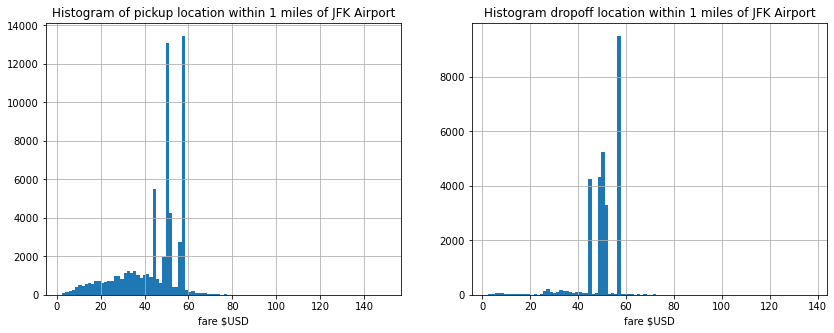

In [36]:
# JFK airport coordinates ---> https://www.travelmath.com/airport/JFK
jfk_airport = (40.6441666667,-73.7822222222)

def plot_airport_fare(location, airport, range=1):
    # select all datapoints with pickup and dropoff location within 1km range of airport
    fig, axis = plt.subplots(1, 2, figsize=(14, 5))
    idx1 = (haversine_vectorize(data_5m.pickup_latitude, data_5m.pickup_longitude, location[0], location[1]) < range)
    data_5m[idx1].fare_amount.hist(bins=100, ax=axis[0])
    axis[0].set_xlabel('fare $USD')
    axis[0].set_title('Histogram of pickup location within {} miles of {}'.format(range, airport))

    idx2 = (haversine_vectorize(data_5m.dropoff_latitude, data_5m.dropoff_longitude, location[0], location[1]) < range)
    data_5m[idx2].fare_amount.hist(bins=100, ax=axis[1])
    axis[1].set_xlabel('fare $USD')
    axis[1].set_title('Histogram dropoff location within {} miles of {}'.format(range, airport))
    
plot_airport_fare(jfk_airport, 'JFK Airport')

In [37]:
data_5m.fare_amount.describe()

count    4.057835e+06
mean     1.218496e+01
std      9.138673e+00
min      2.200000e+00
25%      6.900000e+00
50%      9.300000e+00
75%      1.350000e+01
max      1.495000e+02
Name: fare_amount, dtype: float64

Looking at the above plots of fare amounts of pickups and dropoffs from a range of 1km of jfk airport, and comparing to the fare amount variations in the entire data sample, we can say that there are some fixed fared trips to and from airports.

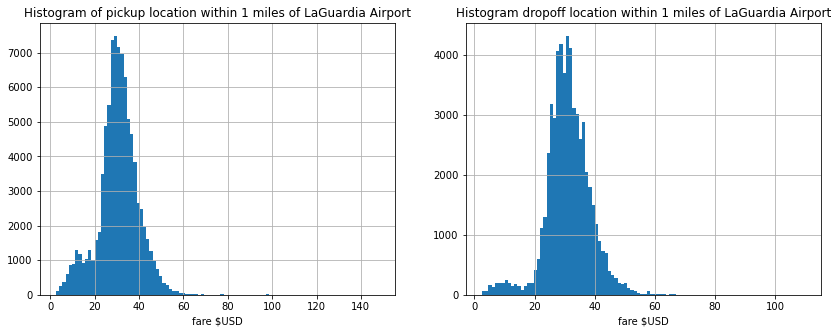

In [38]:
laguardia = (40.77,-73.87) # LaGuardia Airport--> https://www.travelmath.com/airport/LGA
plot_airport_fare(laguardia, 'LaGuardia Airport')

In [40]:
#distance of pickup coordinates from jfk airport
data = data_5m.copy()
data["pickup_jfk_distance"]  = haversine_vectorize(data["pickup_latitude"],data["pickup_longitude"],
                                                      jfk_airport[0],jfk_airport[1])

#distance_from jfk airport to dropoff coordinates
data["dropoff_jfk_distance"] = haversine_vectorize(data["dropoff_latitude"],data["dropoff_longitude"],
                                                      jfk_airport[0],jfk_airport[1])

#pick ups within 1.5km distance from jfk 
jfk_data_pickups  = data[(data["pickup_jfk_distance"] <=  1.5)]
jfk_data_pickups["type"]  = "Pick up"
# jfk_data_pickups = jfk_data_pickups.drop(columns = [ 'jfk_lat','jfk_lon'] ,
#                                          axis = 1)

#dropoffs within 1.5km distance from jfk 
jfk_data_dropoffs = data[(data["dropoff_jfk_distance"] <= 1.5)]
jfk_data_dropoffs["type"] = "Drop off"
# jfk_data_dropoffs = jfk_data_dropoffs.drop(columns = [ 'jfk_lat', 'jfk_lon'] ,
#                                            axis = 1)

#concat jfk pickups and dropoff
jfk = pd.concat([jfk_data_pickups,jfk_data_dropoffs],axis = 0)

#subset data which are not in jfk
not_jfk = data.drop(jfk.index,axis = 0)

#trips to jfk
jfk.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,...,month_year,week_day,hour,fare_log,trip_distance,log_trip_distance,fare_per_km,pickup_jfk_distance,dropoff_jfk_distance,type
1861371,2015-06-30 23:40:28.0000001,52.00,2015-06-30 23:40:28,-73.780014,40.647179,-73.992836,40.733597,2,2015,6,...,2015 - 06-JUN,Tuesday,23,3.951244,20.341858,3.012681,2.556305,0.383007,20.339803,Pick up
4535550,2015-06-30 23:10:02.0000002,57.54,2015-06-30 23:10:02,-73.781937,40.644733,-73.952721,40.787613,1,2015,6,...,2015 - 06-JUN,Tuesday,23,4.052480,21.424600,3.064540,2.685698,0.067428,21.455250,Pick up
1764026,2015-06-30 22:17:08.0000006,57.54,2015-06-30 22:17:08,-73.776779,40.645718,-73.993340,40.752537,1,2015,6,...,2015 - 06-JUN,Tuesday,22,4.052480,21.766536,3.080374,2.643507,0.490238,21.479943,Pick up
90057,2015-06-30 22:14:07.00000014,57.54,2015-06-30 22:14:07,-73.776703,40.645302,-73.994560,40.745377,5,2015,6,...,2015 - 06-JUN,Tuesday,22,4.052480,21.461325,3.066252,2.681102,0.482171,21.131977,Pick up
2854609,2015-06-30 21:54:36.0000001,57.54,2015-06-30 21:54:36,-73.777908,40.646751,-73.974632,40.795818,1,2015,6,...,2015 - 06-JUN,Tuesday,21,4.052480,23.428792,3.153966,2.455952,0.463468,23.379688,Pick up


LaGuardia Airport

In [41]:
#distance of pickup coordinates from jfk airport
data["pickup_lg_distance"]  = haversine_vectorize(data["pickup_latitude"],data["pickup_longitude"],
                                                      laguardia[0],laguardia[1])

#distance_from jfk airport to dropoff coordinates
data["dropoff_lg_distance"] = haversine_vectorize(data["dropoff_latitude"],data["dropoff_longitude"],
                                                      laguardia[0],laguardia[1])

#pick ups within 1.5km distance from jfk 
lg_data_pickups  = data[(data["pickup_lg_distance"] <=  1.5)]
lg_data_pickups["type"]  = "Pick up"
# jfk_data_pickups = jfk_data_pickups.drop(columns = [ 'jfk_lat','jfk_lon'] ,
#                                          axis = 1)

#dropoffs within 1.5km distance from jfk 
lg_data_dropoffs = data[(data["dropoff_lg_distance"] <= 1.5)]
lg_data_dropoffs["type"] = "Drop off"
# jfk_data_dropoffs = jfk_data_dropoffs.drop(columns = [ 'jfk_lat', 'jfk_lon'] ,
#                                            axis = 1)

#concat jfk pickups and dropoff
lg = pd.concat([lg_data_pickups,lg_data_dropoffs],axis = 0)

#subset data which are not in jfk
not_lg = data.drop(lg.index,axis = 0)

#trips to jfk
lg.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,...,hour,fare_log,trip_distance,log_trip_distance,fare_per_km,pickup_jfk_distance,dropoff_jfk_distance,pickup_lg_distance,dropoff_lg_distance,type
179298,2015-06-30 23:22:46.0000001,37.54,2015-06-30 23:22:46,-73.863243,40.769985,-73.974968,40.792805,2,2015,6,...,23,3.625407,9.737057,2.275939,3.855375,15.558505,23.159529,0.568657,9.188857,Pick up
4473498,2015-06-30 23:01:57.0000004,15.50,2015-06-30 23:01:57,-73.863129,40.769932,-73.830437,40.756920,1,2015,6,...,23,2.740840,3.108389,1.134105,4.986506,15.548945,13.171671,0.578336,3.633355,Pick up
4872688,2015-06-30 22:46:51.0000002,47.54,2015-06-30 22:46:51,-73.872597,40.774422,-73.969421,40.761070,1,2015,6,...,22,3.861571,8.282923,2.114196,5.739520,16.354469,20.432135,0.537766,8.426416,Pick up
75418,2015-06-30 22:27:27.0000003,20.50,2015-06-30 22:27:27,-73.885849,40.773113,-73.956100,40.717365,1,2015,6,...,22,3.020425,8.565012,2.147686,2.393458,16.778700,16.759412,1.377944,9.314475,Pick up
2335333,2015-06-30 21:20:35.0000001,21.00,2015-06-30 21:20:35,-73.862671,40.769062,-73.891914,40.718227,5,2015,6,...,21,3.044522,6.162234,1.818439,3.407855,15.445192,12.376717,0.625560,6.041839,Pick up


<b> 4.8 Fare Amount distribution of jfk and non-jfk airport

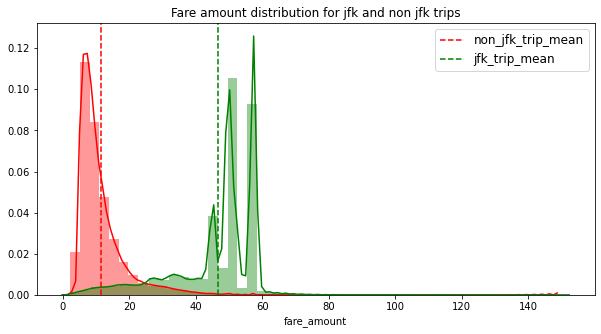

In [42]:
plt.figure(figsize = (10,5))
sns.distplot(not_jfk["fare_amount"],color = "r")
sns.distplot(jfk["fare_amount"],color = "g")
plt.axvline(not_jfk["fare_amount"].mean(),color = "r",linestyle = "dashed",label = "non_jfk_trip_mean")
plt.axvline(jfk["fare_amount"].mean(),color = "g",linestyle = "dashed",label = "jfk_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Fare amount distribution for jfk and non jfk trips")
plt.show()

<b> 4.9 Average fare amount for jfk and non jfk airports 

      type  fare_amount
0      jfk    46.514466
1  non_jfk    11.354378


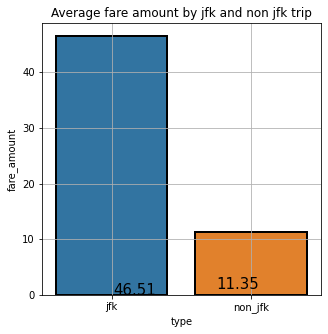

In [43]:
#average fare amount by jfk and non jfk trip  
avg_fares = pd.DataFrame({"type" : ["jfk","non_jfk"], "fare_amount":[jfk["fare_amount"].mean(),not_jfk["fare_amount"].mean()]})

#plot
plt.figure(figsize = (5,5))

print(avg_fares)    
ax1 = sns.barplot(x = "type" ,y = "fare_amount",data = avg_fares,linewidth = 2,edgecolor = "k"*2)
plt.grid(True)
plt.title("Average fare amount by jfk and non jfk trip")
pos = 0.01
for i,j in enumerate(np.around(avg_fares["fare_amount"].values,2)) :
    ax1.text(pos,i,j,fontsize = 15)
    pos = .75
plt.show()

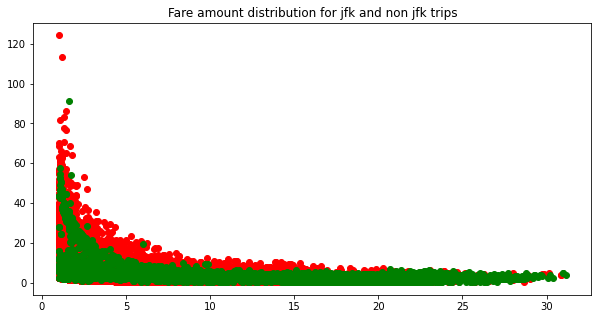

In [44]:
plt.figure(figsize = (10,5))
plt.scatter(not_jfk['trip_distance'],not_jfk["fare_per_km"],color = "r")
plt.scatter(jfk['trip_distance'],jfk["fare_per_km"],color = "g")
plt.title("Fare amount distribution for jfk and non jfk trips")
plt.show()

<b> 4.10 Fare amount distribution of LaGuardia and non Laguardia trips 

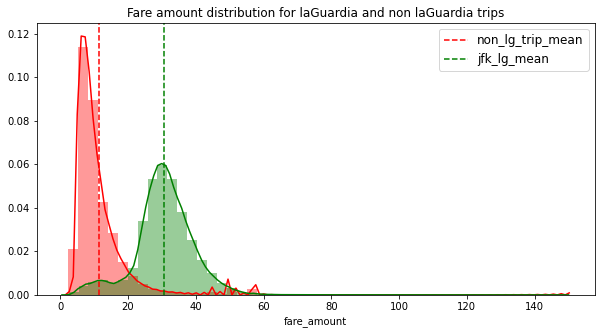

In [45]:
plt.figure(figsize = (10,5))
sns.distplot(not_lg["fare_amount"],color = "r")
sns.distplot(lg["fare_amount"],color = "g")
plt.axvline(not_lg["fare_amount"].mean(),color = "r",linestyle = "dashed",label = "non_lg_trip_mean")
plt.axvline(lg["fare_amount"].mean(),color = "g",linestyle = "dashed",label = "lg_trip_mean")
plt.legend(loc = "best",prop= {"size" : 12})
plt.title("Fare amount distribution for laGuardia and non laGuardia trips")
plt.show()

<b> 4.11 Average Fare amount of LaGuardia and non Laguardia trips 

     type  fare_amount
0      lg    30.719320
1  non_lg    11.439853


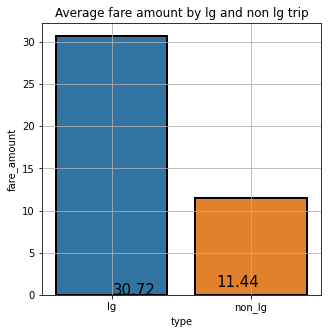

In [46]:
#average fare amount by jfk and non jfk trip  
avg_fares = pd.DataFrame({"type" : ["lg","non_lg"], "fare_amount":[lg["fare_amount"].mean(),not_lg["fare_amount"].mean()]})

#plot
plt.figure(figsize = (5,5))

print(avg_fares)    
ax1 = sns.barplot(x = "type" ,y = "fare_amount",data = avg_fares,linewidth = 2,edgecolor = "k"*2)
plt.grid(True)
plt.title("Average fare amount by lg and non lg trip")
pos = 0.01
for i,j in enumerate(np.around(avg_fares["fare_amount"].values,2)) :
    ax1.text(pos,i,j,fontsize = 15)
    pos = .75
plt.show()

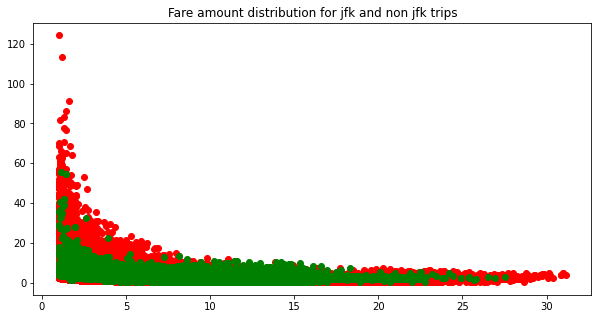

In [47]:
plt.figure(figsize = (10,5))
plt.scatter(not_lg['trip_distance'],not_lg["fare_per_km"],color = "r")
plt.scatter(lg['trip_distance'],lg["fare_per_km"],color = "g")
plt.title("Fare amount distribution for jfk and non jfk trips")
plt.show()

<b> 4.12 Fare varies with hour of the day:

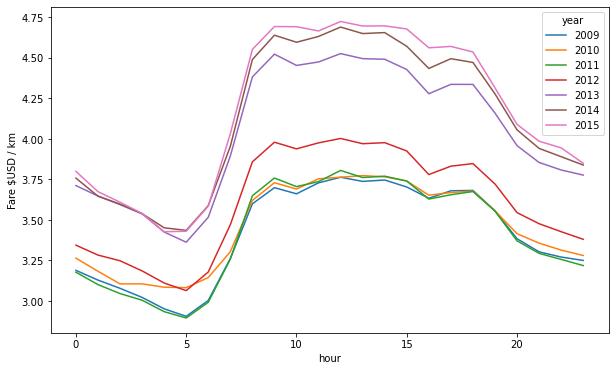

In [48]:
data_5m.pivot_table('fare_per_km', index='hour', columns='year').plot(figsize=(10,6))
plt.ylabel('Fare $USD / km');

Trips are more costly at the middle hours of the day than in the morning or at night.

<h3>5. Time Series Forecasting of monthly Fare amount for all years

In [54]:
import datetime
#Data - total fare amount by month from 2009 to 2015-06
fare_with_time = total_fare
fare_with_time["date"] = fare_with_time["year"].astype(str) + "-" + fare_with_time["month"].astype(str)
#selecting columns
fare_with_time = fare_with_time[["date","fare_amount"]]
#convert to date format
fare_with_time["date"] = pd.to_datetime(fare_with_time["date"],format = "%Y-%m")
fare_with_time.index   = fare_with_time["date"]
fare_with_time = fare_with_time.drop(columns  = ["date"],axis = 1)
fare_with_time.head(5)

,fare_amount
date,
2009-01-01,569582.93
2009-02-01,546977.37
2009-03-01,596908.89
2009-04-01,586212.35
2009-05-01,614697.55


<b> 5.1 Plotting the time series data for total fare amount for all months in the years from 2009 to 2015

Text(0.5, 1.0, 'Time series Visualization')

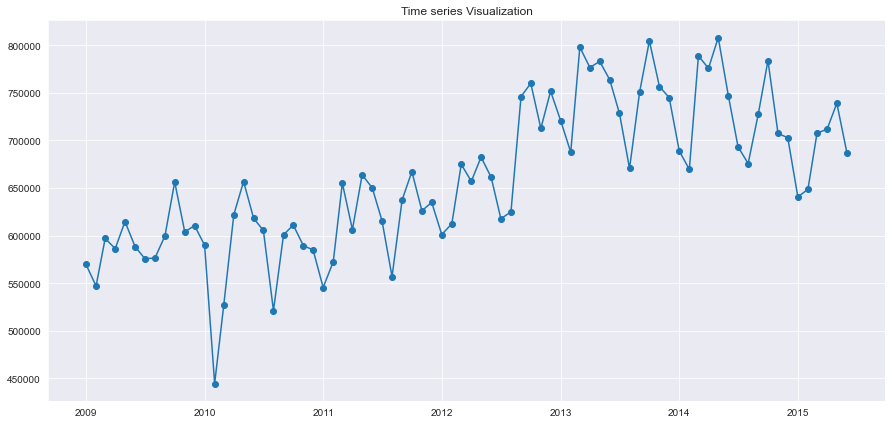

In [55]:
plt.figure(figsize = (15,7))
plt.scatter(x = fare_with_time.index,y = fare_with_time.fare_amount)
plt.plot(fare_with_time.index,fare_with_time.fare_amount)
plt.title("Time series Visualization")

<b> 5.2 Plotting moving average for the time series</b>

Moving average smoothing of time series is used to model the trend in the time series.

In [56]:
def plot_moving_average(ts) :
    plt.figure(figsize = (15,7))
    #rolling mean and standard deviation
    rolling_mean = ts["fare_amount"].rolling(window = 12,center = False).mean()
    rolling_std  = ts["fare_amount"].rolling(window = 12,center = False).std()
    #plotting
    plt.scatter(ts.index,ts["fare_amount"],color="blue")
    plt.plot(ts.index,ts["fare_amount"],color="blue",label = "time_series")
    plt.plot(rolling_mean.index,rolling_mean.values,color = "black",label="rolling_mean")
    plt.plot(rolling_std.index,rolling_std.values,color ="yellow", label ="rolling_std")
    plt.legend()
    plt.show()

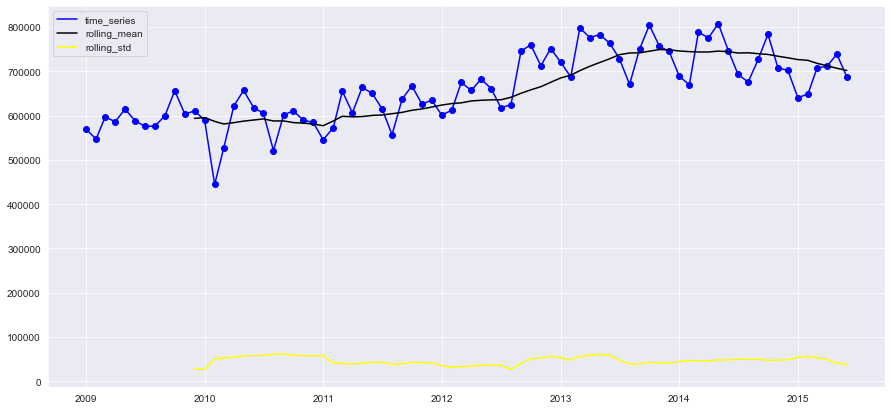

In [57]:
plot_moving_average(fare_with_time)

<b>5.3 Checking for stationarity of time series(Statistical)

<b>5.3.1 Augmented Dickey-Fuller(ADF) test

In [58]:
from statsmodels.tsa.stattools import adfuller
def ADF(data):
    test = adfuller(data['fare_amount'])
    result_name = ["ADF Test Statistic","p-value","lags used","no of observations"] 
    result_data = pd.Series(test[:4],index = result_name)
    # result_dict = {}

    for key,value in test[4].items() :
        result_data["Critical value (%s)"%key] = value 

    print (result_data)

ADF(fare_with_time)

ADF Test Statistic      -1.192219
p-value                  0.676934
lags used               12.000000
no of observations      65.000000
Critical value (1%)     -3.535217
Critical value (5%)     -2.907154
Critical value (10%)    -2.591103
dtype: float64


In  the above test:
1. Null Hypothesis(H0): Time series has a unit root , meaning it is non stationary
2. Alternate Hypothesis(H1): Time series does not have a unit root,meaning it is stationary.

Here the test statistics is negative(-1.202851).Hence looking at this alone we are more likely to reject the null hypothesis.
However the test statistics value is larger than the critical values.So we fail to reject the null hypothesis and the time series can be considered non stationary.

<b>5.3.2 Kwiatkowski-Phillip-Schmidt-Shin(KPSS) Test

In [59]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(fare_with_time["fare_amount"])

result_name = ["KPSS Test Statistic","p-value","lags used"] 
result_data = pd.Series(kpss_test[:3],index = result_name)
# result_dict = {}

for key,value in kpss_test[3].items() :
    result_data["Critical value (%s)"%key] = value 
print(result_data)

KPSS Test Statistic       0.586832
p-value                   0.023833
lags used                12.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64


In the above test:

1. Null Hypothesis(H0): The series is trend stationary
2. Alternate Hypothesis: The series has unit root(series is not stationary)
    
In the output of the test, test statistic 0.588 is lesser than critical value at 1% significance level.
Hence we accept the null hypothesis that the series is trend stationary.

<h3>5.4 Eliminating Trend:</h3>

Moving Average can be seen as a method to remove seasonality and noise from the observed time series and to model the trend.So we difference the moving average transformed time series from original time series in log scale to eliminate the trend and get the random noise(and seasonality) in data.

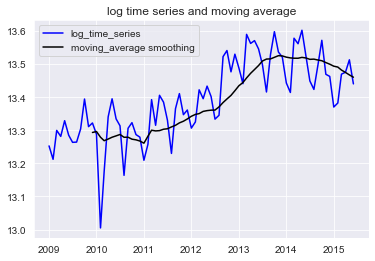

ADF Test Statistic      -1.116004
p-value                  0.708647
lags used               11.000000
no of observations      55.000000
Critical value (1%)     -3.555273
Critical value (5%)     -2.915731
Critical value (10%)    -2.595670
dtype: float64


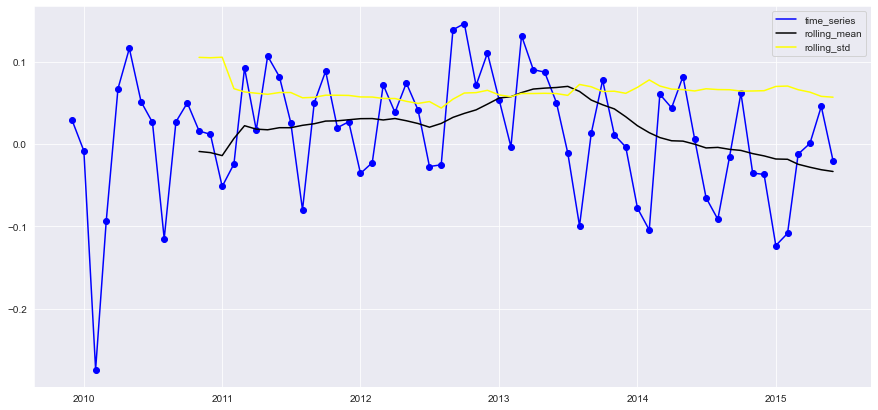

In [60]:
#log of timeseries
log_fare_with_time = np.log(fare_with_time)
#rolling average of log timeseries
rol_avg_log_with_time = log_fare_with_time["fare_amount"].rolling(window = 12,center = False).mean()

#plotting log timeseries and rolling mean
plt.plot(log_fare_with_time.index,log_fare_with_time.fare_amount,color = "blue",label ="log_time_series")
plt.plot(rol_avg_log_with_time.index,rol_avg_log_with_time.values,color ="black",label="moving_average smoothing")
plt.title("log time series and moving average")
plt.legend()
plt.show()

#differencing to remove trend
log_fare_diff_with_time = log_fare_with_time - rol_avg_log_with_time.to_frame()
log_fare_diff_with_time.dropna(inplace = True)
ADF(log_fare_diff_with_time)
plot_moving_average(log_fare_diff_with_time)

Exponential Weighted Moving Average:
    

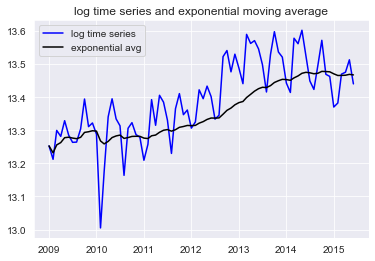

ADF Test Statistic      -1.105700
p-value                  0.712793
lags used                5.000000
no of observations      72.000000
Critical value (1%)     -3.524624
Critical value (5%)     -2.902607
Critical value (10%)    -2.588679
dtype: float64


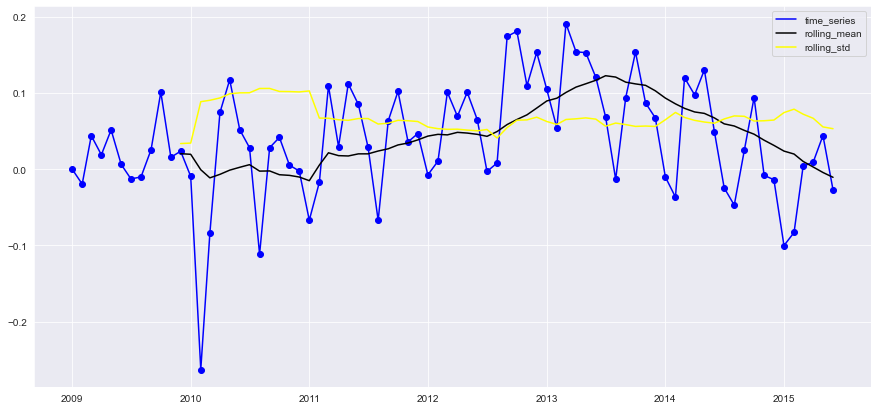

In [61]:
#exponential moving average of log time series
exp_avg_log_ts = log_fare_with_time["fare_amount"].ewm(halflife = 12).mean()

#plotting
plt.plot(log_fare_with_time.index,log_fare_with_time["fare_amount"],color="blue",label = "log time series")
plt.plot(exp_avg_log_ts.index,exp_avg_log_ts.values,color="black",label = "exponential avg")
plt.title("log time series and exponential moving average")
plt.legend()
plt.show()

#difference
exp_diff_time_series = log_fare_with_time - exp_avg_log_ts.to_frame()
ADF(exp_diff_time_series)
plot_moving_average(exp_diff_time_series)

<b> 5.5 Differencing </b>

Differencing is used to remove trend and seasonality in time series

ADF Test Statistic     -6.222925e+00
p-value                 5.170707e-08
lags used               1.200000e+01
no of observations      6.300000e+01
Critical value (1%)    -3.538695e+00
Critical value (5%)    -2.908645e+00
Critical value (10%)   -2.591897e+00
dtype: float64


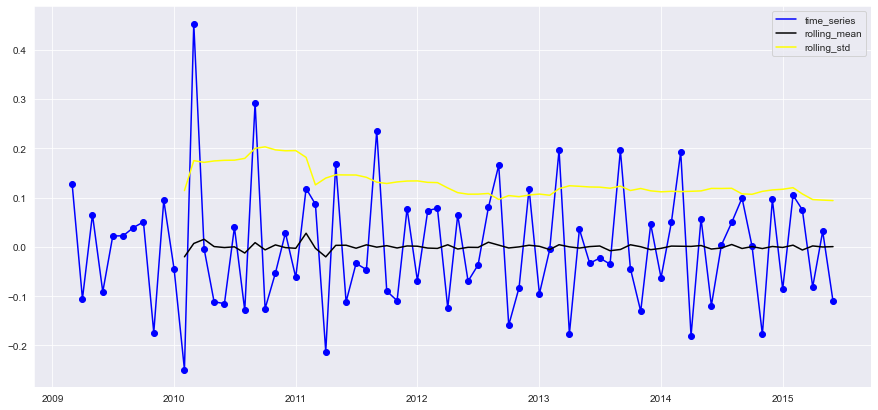

In [100]:
def difference_trend(ts,interval):
    while(interval > 0):
        fare_diff = ts - ts.shift()
        ts = fare_diff
        ts.dropna(inplace = True)
        interval = interval-1
    return ts

fare_diff = difference(log_fare_with_time,2)

ADF(fare_diff)
plot_moving_average(fare_diff)

ADF Test Statistic      -4.564895
p-value                  0.000150
lags used                9.000000
no of observations      42.000000
Critical value (1%)     -3.596636
Critical value (5%)     -2.933297
Critical value (10%)    -2.604991
dtype: float64


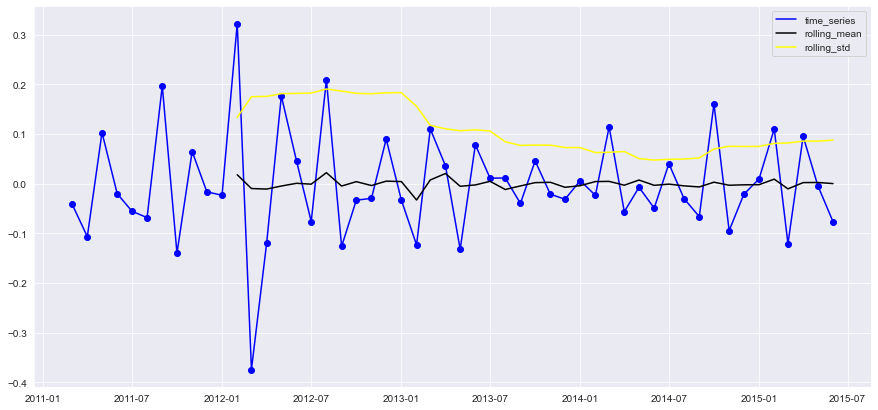

In [114]:
def difference_seasonality(ts,interval):
        fare = ts - ts.shift(interval)
        fare.dropna(inplace = True)
        return fare

fare_diff_trend_seasonality = difference_seasonality(fare_diff,24)

ADF(fare_diff_trend_seasonality)
plot_moving_average(fare_diff_trend_seasonality)

<h3> 5.6 Decomposition </h3>

Time Series can be broken  down into Systematic(Can be Described and Modeled) and Non Systematic(cannot be directly modelled) as follows:<br>

1. Level : the average value in the series
2. Trend : The increasing or decreasing values in the series
3. Seasonality: The recurring short-term cycle in the series.
4. Noise: The random Variation in the series.

A time series can be thought of as an 'Additive' and/or 'Multiplicative' construction of these four components.<br>

Decomposition is a statistical task that deconstructs a time series into its components mentioned above.Its provides a structured way of thinking about a time series forecasting  problem,both in terms of modelling complexity and specifically in terms of how to best capture each of these components in a given model.<br>

The statsmodels library of python provides an implementation of the naive or classical decomposition method in the function ``seasonal_decompose()``.<br>
However, sometimes this naive models are not able to separate the noise in the time series.In such casee we can use more advanced decompostion techniques like ``Loess or STL decompostion``


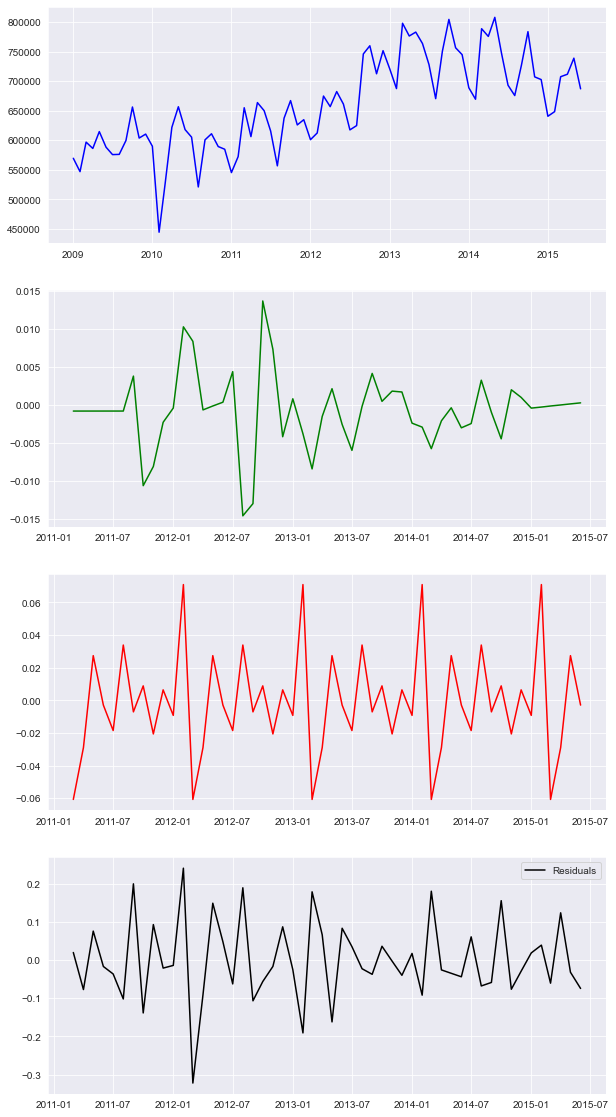

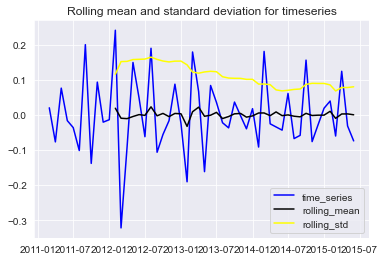

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

#decompose
result = seasonal_decompose(log_fare_with_time,freq=12, extrapolate_trend='freq')

#trend
trend  = result.trend
#seasonality
seasonality = result.seasonal
#residuals
residuals   = result.resid

f, ax = plt.subplots(4,1,figsize=(10,20))
#plotting
ax[0].plot(fare_with_time.index,fare_with_time.fare_amount,color = "blue",label = "log_Series")
ax[1].plot(trend.index,trend.values,color = "green",label = "Trend")
ax[2].plot(seasonality.index,seasonality.values,color = "red",label = "Seasonality")
ax[3].plot(residuals.index,residuals.values,color = "black",label = "Residuals")
plt.legend()
plt.show()


#stationary test for residuals
residuals.dropna(inplace = True)

#Plotting Stationary Residuals
rolling_mean = residuals.rolling(window = 12,center = False).mean()
rolling_std  = residuals.rolling(window = 12,center = False).std()
#plotting
plt.plot(residuals.index,residuals.values,color = "blue",label = "time_series")
plt.plot(rolling_mean.index,rolling_mean.values,color = "black",label = "rolling_mean")
plt.plot(rolling_std.index,rolling_std.values,color = "yellow",label = "rolling_std")
plt.title("Rolling mean and standard deviation for timeseries")
plt.legend()
plt.show()

Above, we are plotting the residuals of the time series after removing `trend` and `seasonality`.

<h3>5.7 Time Series Forecasting Methods: </h3>

In [38]:
from statsmodels.tsa.arima_model import ARIMA

def model(ts,p,d,q,plot = True) :
    model   = ARIMA(ts , order = (p,d,q))
    results = model.fit(disp = -1)
    fits = results.fittedvalues
    t1 = plt.plot(fits.index,fits.values,color = "blue",label = "fit value")
    t2 = plt.plot(fare_diff.index,fare_diff["fare_amount"],color = "black",label = "difference of log values")
    plt.title("ARIMA model p = " + str(p) + ", d = " + str(d) + ", q = " + str(q))
    print(results.summary())
    print("**********************")

    print("Plot of Residuals")
    residuals = pd.DataFrame(results.resid)
    residuals.plot()
    plt.show()

    print("Density of the residuals")
    residuals.plot(kind = 'kde')
    pyplot.show()

    print(residuals.describe())
    return results,fits
    
def predict_plot(ts,result):
    forecast = result.forecast(steps = 100)[0]
    
    a = ts.reset_index()
    last_date = a['date'][75]
    b = []
    year  = last_date.year
    month = last_date.month
    for i in range(1,101):
        if((month + i)%12 == 1):
            year = year +1
        if((month + i)%12 == 0):
            b.append([pd.to_datetime(str(year)+'-'+str(12)+'-'+ str(last_date.day)) , forecast[i-1] ])
        else:
            b.append([pd.to_datetime(str(year)+'-'+str((month +i)%12)+'-'+ str(last_date.day)) , forecast[i-1] ])
        
    predicted_df = pd.DataFrame(b,columns = ['date','fare_amount'])
    print(predicted_df.shape)
    print(ts.reset_index().shape)
    new_df = ts.reset_index().append(predicted_df,ignore_index = True)
    print(new_df.shape)
    print(new_df)
    
    #plotting
#     cols = np.where(new_df.index > 77,'r','b')
    plt.plot(new_df.date,new_df.fare_amount,color = 'r')
    

<h4>5.7.1 AutoRegressive Integrated Moving Average(ARIMA)</h4>

                             ARIMA Model Results                              
Dep. Variable:          D.fare_amount   No. Observations:                   77
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  84.508
Method:                       css-mle   S.D. of innovations              0.081
Date:                Sun, 04 Oct 2020   AIC                           -163.016
Time:                        06:48:32   BIC                           -155.984
Sample:                    02-01-2009   HQIC                          -160.203
                         - 06-01-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0027      0.008      0.337      0.736      -0.013       0.019
ar.L1.D.fare_amount    -0.1441      0.113     -1.276      0.202      -0.365       0.077
                

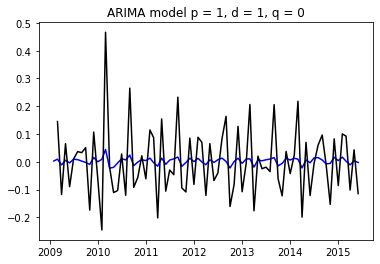

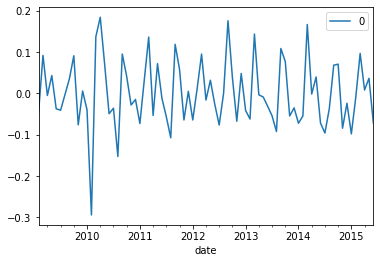

Density of the residuals


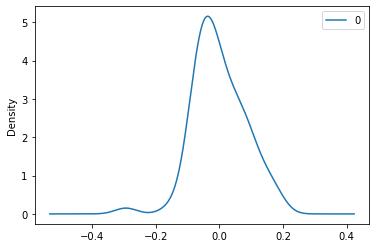

               0
count  77.000000
mean   -0.000087
std     0.081268
min    -0.293964
25%    -0.054541
50%    -0.009808
75%     0.048188
max     0.184208


In [39]:
results,fits = model(log_fare_with_time,1,1,0)
# predict_plot(results)

(100, 2)
(78, 2)
(178, 2)
          date  fare_amount
0   2009-01-01    13.982861
1   2009-02-01    13.939333
2   2009-03-01    14.040606
3   2009-04-01    14.024157
4   2009-05-01    14.072900
..         ...          ...
173 2023-04-01    14.446663
174 2023-05-01    14.449377
175 2023-06-01    14.452092
176 2023-07-01    14.454806
177 2023-08-01    14.457521

[178 rows x 2 columns]


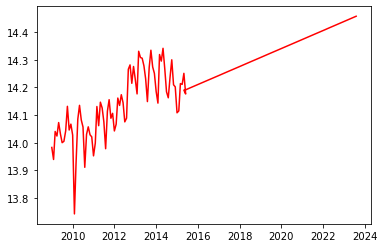

In [40]:
predict_plot(log_fare_with_time, results)

In [50]:
data_5m.to_csv("/data_5m")

In [32]:
data_5m = pd.read_csv("/data_5m",nrows = 1000000)
data_5m.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,month_name,month_year,week_day,hour,fare_log,trip_distance,log_trip_distance,fare_per_km
0,2203030,2015-06-30 23:59:03.0000004,11.0,2015-06-30 23:59:03,-73.969475,40.750282,-73.993965,40.751568,1,2015,6,30,06-JUN,2015 - 06-JUN,Tuesday,23,2.397895,2.066623,0.725916,5.322693
1,2031461,2015-06-30 23:56:50.0000001,14.5,2015-06-30 23:56:50,-73.992104,40.734531,-73.960335,40.775703,1,2015,6,30,06-JUN,2015 - 06-JUN,Tuesday,23,2.674149,5.299472,1.667607,2.736121
2,3088533,2015-06-30 23:56:00.0000001,20.0,2015-06-30 23:56:00,-73.970154,40.757011,-73.962608,40.708641,1,2015,6,30,06-JUN,2015 - 06-JUN,Tuesday,23,2.995732,5.412584,1.688727,3.695093
3,3211962,2015-06-30 23:55:51.0000007,6.5,2015-06-30 23:55:51,-74.010147,40.720520,-74.000557,40.727139,1,2015,6,30,06-JUN,2015 - 06-JUN,Tuesday,23,1.871802,1.092358,0.088339,5.950428
4,785182,2015-06-30 23:53:49.0000003,7.5,2015-06-30 23:53:49,-73.959969,40.762405,-73.953064,40.782688,1,2015,6,30,06-JUN,2015 - 06-JUN,Tuesday,23,2.014903,2.327617,0.844845,3.222180


In [33]:
data_5m = data_5m.sort_values(by='pickup_datetime')

<h3> 6. ML Models </h3>

In [62]:
features = ['year', 'month','day','hour', 'trip_distance','log_trip_distance', 'passenger_count']
X = data_5m[features].values
y = data_5m['fare_amount'].values

In [63]:
from sklearn.metrics import mean_squared_error, explained_variance_score

def prediction_plots(y, y_pred, figsize=(7,10), title=''):
    fig, axis = plt.subplots(2,1, figsize=figsize)
    axis[0].scatter(y, y_pred)
    axis[0].plot([np.min(y), np.max(y)], [np.min(y_pred), np.max(y_pred)], c='black')
    axis[0].set_xlabel('y')
    axis[0].set_ylabel('y_predicted')
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    explained_var_score = explained_variance_score(y, y_pred)
    axis[0].set_title('rmse = {}, explained_var_score = {}'.format(np.round(rmse,2), np.round(explained_var_score,2)))
    
    axis[1].hist(y-y_pred, bins=50)
    mean = np.mean(y-y_pred)
    std = np.std(y-y_pred)
    axis[1].set_xlabel('y - y_pred')
    axis[1].set_title('Histrogram prediction error, mean = {}, std = {}'.format(np.round(mean,2), np.round(std,2)))

    fig.suptitle(title)


In [64]:
from sklearn.model_selection import train_test_split

X_train,y_train = X[:int(len(X)*0.80)],y[:int(len(X)*0.80)]
X_val,y_val = X[int(len(X)*0.80):],y[int(len(X)*0.80):]
X_train.shape,X_val.shape

((800000, 7), (200000, 7))

<b> 6.1 Linear Regression

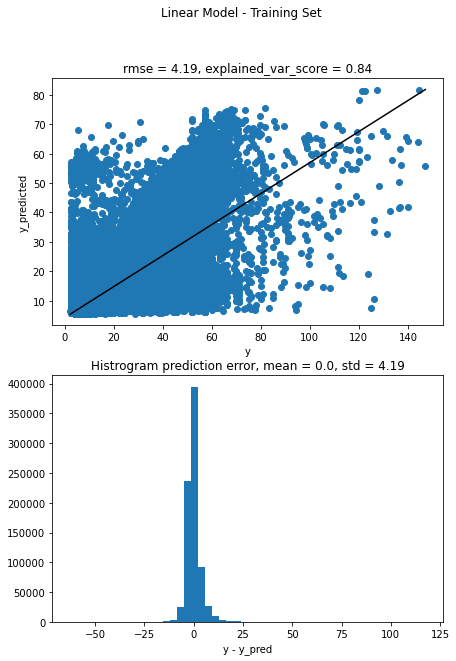

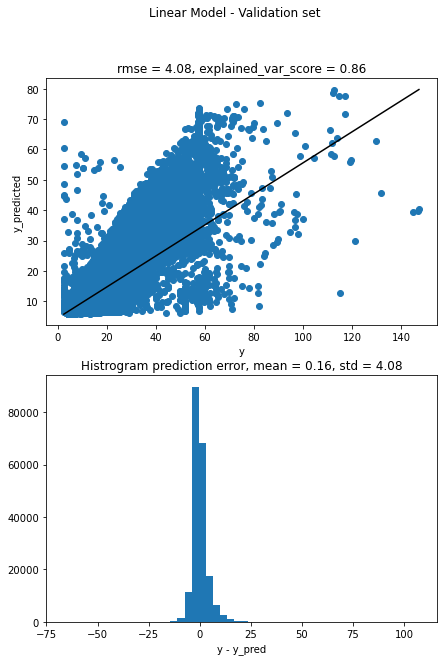

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

model = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
prediction_plots(y_train, y_train_pred, title='Linear Model - Training Set')

y_val_pred = model.predict(X_val)
prediction_plots(y_val, y_val_pred, title='Linear Model - Validation set')



<b> 6.2 Fandom Forest Regression </b>

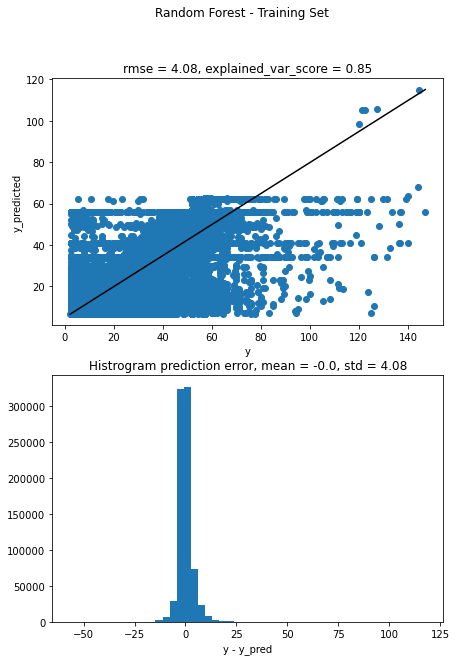

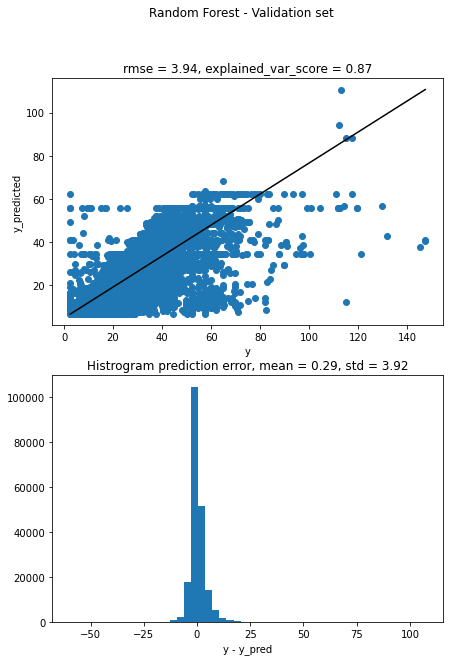

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

model2 = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("rf",RandomForestRegressor(n_estimators = 10,max_depth = 5,n_jobs = -1)),
    ))
model2.fit(X_train, y_train)

y_train_pred = model2.predict(X_train)
prediction_plots(y_train, y_train_pred, title='Random Forest - Training Set')

y_val_pred = model2.predict(X_val)
prediction_plots(y_val, y_val_pred, title='Random Forest - Validation set')

<b> 6.2.1 Predicting the fare amount for a test example

In [56]:
x_testing = [X_val[1003,:]]
print(y_val[1003])
prediction = model2.predict(x_testing)
prediction

11.5


array([10.20429561])

<b> 6.3 Gradient Boosting using light gbm </b>

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


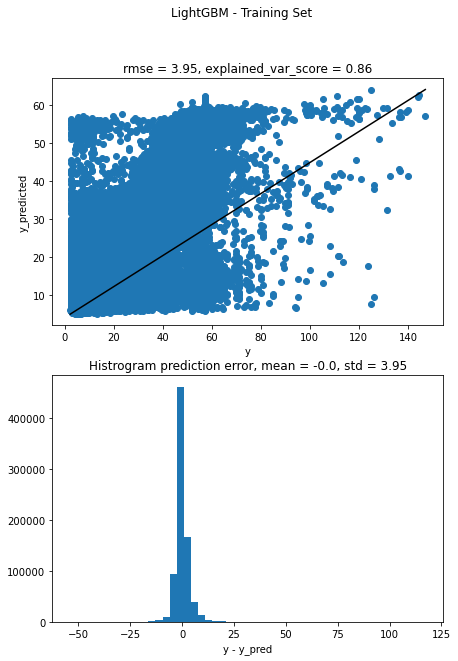

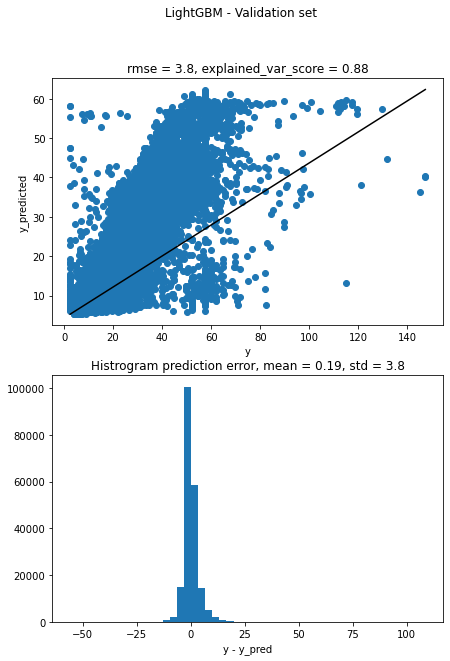

In [70]:
import lightgbm as lgbm
import warnings
warnings.filterwarnings("ignore")

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_alpha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

train_set = lgbm.Dataset(X_train, y_train, silent=True)
model3 = lgbm.train(params, train_set = train_set, num_boost_round=300)

y_train_pred = model3.predict(X_train, num_iteration = model.best_iteration)
prediction_plots(y_train, y_train_pred, title='LightGBM - Training Set')

y_val_pred = model3.predict(X_val, num_iteration = model.best_iteration)
prediction_plots(y_val, y_val_pred, title='LightGBM - Validation set')

<b> 6.4 Running model multiple times to check the change in RMSE </b>

In [82]:
def plot_multiple_run_rmse(model, X, y, M=400, test_size=0.25, figsize=(10,4), title=''):
    rmse_train, rmse_test = [], []
    for _ in range(M):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    jplot = sns.jointplot(np.array(rmse_train), np.array(rmse_test), kind='scatter', stat_func=None, size=5)
    jplot.set_axis_labels("RMSE training (mean={})".format(np.round(np.mean(rmse_train),2)), 
                      "RMSE test (mean={})".format(np.round(np.mean(rmse_test),2)))
    jplot.fig.suptitle('{} (N={}, test_size={})'.format(title, N, test_size))

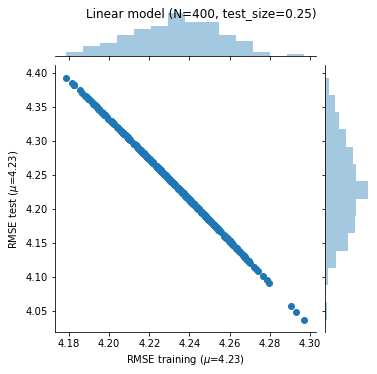

In [77]:
plot_multiple_run_rmse(model, X[:100_000,:], y[:100_000], title='Linear model')